In [1]:
deps_path = '/kaggle/input/czii-cryoet-dependencies'

In [2]:
! cp -r /kaggle/input/czii-cryoet-dependencies/asciitree-0.3.3/ asciitree-0.3.3/

In [3]:
! pip wheel asciitree-0.3.3/asciitree-0.3.3/
! cp /kaggle/input/best-weights-code/* ./ -r
! cp /kaggle/input/best-weights ./ -r
! cp /kaggle/input/voxhrnet-v2/voxhrnetV2.py ./ -r
! cp /kaggle/input/load-vox-net/load_model.py ./ -r
! cp /kaggle/input/hrnet-v1/* ./ -r

Processing ./asciitree-0.3.3/asciitree-0.3.3
  Preparing metadata (setup.py) ... - done
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=7d5679f7af311f04ca5ac2e7646ee2837cfcade72f4f8dc0b197651b376ca1fb
  Stored in directory: /root/.cache/pip/wheels/77/df/a8/c6318c87827b53ea48635bf95b1249186d3d21f041176e062e
Successfully built asciitree


In [4]:
! cp /kaggle/input/d/luoziqian/unet2e3d-6c/* ./
! cp /kaggle/input/voxhrnet/voxhrnet.py ./ -r
! cp /kaggle/input/vox-networks-dataset/voxhrnet.py ./
! cp /kaggle/input/vox-networks-dataset/config_small.yaml ./
! cp /kaggle/input/vox-networks-dataset/model10.py ./
! cp /kaggle/input/voxresnet-v0/voxresnetV0.py ./

In [5]:
!pip install asciitree-0.3.3-py3-none-any.whl
! pip install /kaggle/input/einops-0-8-none-any/einops-0.8.0-py3-none-any.whl

Processing ./asciitree-0.3.3-py3-none-any.whl
Processing /kaggle/input/einops-0-8-none-any/einops-0.8.0-py3-none-any.whl


In [6]:
! pip install -q --no-index --find-links {deps_path} --requirement {deps_path}/requirements.txt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dask-expr 1.1.15 requires dask==2024.9.1, but you have dask 2024.11.0 which is incompatible.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have google-cloud-storage 1.44.0 which is incompatible.
kfp 2.5.0 requires requests-toolbelt<1,>=0.8.0, but you have requests-toolbelt 1.0.0 which is incompatible.
rapids-dask-dependency 24.8.0a0 requires dask==2024.7.1, but you have dask 2024.11.0 which is incompatible.
rapids-dask-dependency 24.8.0a0 requires distributed==2024.7.1, but you have distributed 2024.11.0 which is incompatible.


In [7]:
! pip install /kaggle/input/vox-networks-dataset/yacs-0.1.8-py3-none-any.whl

Processing /kaggle/input/vox-networks-dataset/yacs-0.1.8-py3-none-any.whl


In [8]:
from typing import List, Tuple, Union
import numpy as np
import torch
from monai.data import DataLoader, Dataset, CacheDataset, decollate_batch
from monai.transforms import (
    Compose, 
    EnsureChannelFirstd, 
    Orientationd,  
    AsDiscrete,  
    RandFlipd, 
    RandRotate90d, 
    NormalizeIntensityd,
    RandCropByLabelClassesd,
)

In [9]:
import os
import shutil
import tempfile
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from monai.transforms import (
    Compose,
    Orientationd,
    RandFlipd,
    RandShiftIntensityd,
    RandRotate90d,
)
from monai.data import (
    ThreadDataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)
from monai.inferers import sliding_window_inference
from monai.networks.nets import SwinUNETR
from monai.metrics import DiceMetric
from monai.losses import DiceCELoss
import torch
import einops
import warnings


warnings.filterwarnings("ignore")
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define some helper functions


### Patching helper functions

These are mostly used to split large volumes into smaller ones and stitch them back together. 

In [10]:
def calculate_patch_starts_with_overlap(
    dimension_size: int, patch_size: int, overlap: int
) -> List[int]:
    if dimension_size <= patch_size:
        return [0]

    num_patches = np.ceil(
        (dimension_size - overlap) / (patch_size - overlap) + 1
    ).astype(int)
    patch_starts = []
    for i in range(num_patches):
        pos = int(i * (patch_size - overlap))
        if pos + patch_size > dimension_size:
            pos = dimension_size - patch_size
        if pos not in patch_starts:
            patch_starts.append(pos)
    return patch_starts


def extract_3d_patches_overlap(
    arrays: List[np.ndarray],
    patch_sizes: Tuple[int, int, int],
    overlap_sizes: Tuple[int, int, int],
) -> Tuple[List[np.ndarray], List[Tuple[int, int, int]]]:

    patch_starts_x = calculate_patch_starts_with_overlap(
        arrays[0].shape[0], patch_sizes[0], overlap_sizes[0]
    )
    patch_starts_y = calculate_patch_starts_with_overlap(
        arrays[0].shape[1], patch_sizes[1], overlap_sizes[1]
    )
    patch_starts_z = calculate_patch_starts_with_overlap(
        arrays[0].shape[2], patch_sizes[2], overlap_sizes[2]
    )
    patch_size_d, patch_size_h, patch_size_w = patch_sizes
    patches = []
    coordinates = []
    for arr in arrays:
        for x in patch_starts_x:
            for y in patch_starts_y:
                for z in patch_starts_z:
                    patch = arr[
                        x : x + patch_size_d, y : y + patch_size_h, z : z + patch_size_w
                    ]
                    patches.append(patch)
                    coordinates.append((x, y, z))

    return patches, coordinates

## Reading in the data

In [11]:
TRAIN_DATA_DIR = "/kaggle/input/create-numpy-dataset-exp-name"
TEST_DATA_DIR = "/kaggle/input/czii-cryo-et-object-identification"

## Initialize the model

This model is pretty much directly copied from [3D U-Net PyTorch Lightning distributed training](https://www.kaggle.com/code/zhuowenzhao11/3d-u-net-pytorch-lightning-distributed-training)

In [12]:
from torch.nn.modules import Module
from torch import nn

In [13]:
!cp -r /kaggle/input/unet2d3e/* ./

In [14]:
import lightning.pytorch as pl

from monai.networks.nets import UNet
from monai.losses import TverskyLoss
from monai.metrics import DiceMetric

# use warmup lr scheduler
from torch.optim.lr_scheduler import (
    CosineAnnealingLR,
    CosineAnnealingWarmRestarts,
    StepLR,
)
import lightning.pytorch as pl

from monai.networks.nets import UNet, AttentionUnet
from monai.losses import TverskyLoss
from monai.metrics import DiceMetric

# use warmup lr scheduler
from torch.optim.lr_scheduler import (
    CosineAnnealingLR,
    CosineAnnealingWarmRestarts,
    StepLR,
)

In [15]:
config_v2 = {
    "MODEL": {
        "NAME": "voxhrnet",
        "EXTRA": {
            "STAGE2": {
                "NUM_MODULES": 1,
                "NUM_BRANCHES": 2,
                "BLOCK": "BASIC",
                "NUM_BLOCKS": [3, 3],
                "NUM_CHANNELS": [16, 32],
            },
            "STAGE3": {
                "NUM_MODULES": 1,
                "NUM_BRANCHES": 3,
                "BLOCK": "BASIC",
                "NUM_BLOCKS": [3, 3, 3],
                "NUM_CHANNELS": [16, 32, 64],
            },
        },
    }
}

In [16]:
from monai.networks.nets import UNet,SegResNet,DynUNet
from custom_vnet import CustomVNet
from model2_6c import Net
# from voxhrnet import build_model
from voxhrnetV2 import build_model as build_model_v2
from load_model import build_model as build_model_v3
from model10_v1 import build_model as build_model_v4
from voxresnetV0 import VoxResNet as VoxResNetV0

basic_unet = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=7,
    channels=(48, 64, 80, 80),
    strides=(2, 2, 1),
    num_res_units=1,
)
basic_unet_1 = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=7,
    channels=(48, 64, 80, 80),
    strides=(2, 2, 1),
    num_res_units=2,
)
basic_unet_6c = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=6,
    channels=(48, 64, 80, 80),
    strides=(2, 2, 1),
    num_res_units=1,
)

segresnet_6c_v1 = SegResNet(
    in_channels=1,
    out_channels=6,
    dropout_prob=0.1,
    upsample_mode="deconv",
)

basic_unet2e3d = Net(
    out_channels=6,
    arch="resnet18d",
    decoder_dim=[80, 80, 64, 32, 16],
    pretrained=False,
)

basic_dynunet_v1 = DynUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=6,
    kernel_size=(3, 3, 3, 3),
    strides=((1, 1, 1), 2, 2, 1),
    upsample_kernel_size=(2, 2, 1),
    filters=[16, 24, 48, 80, 80],
    norm_name="instance",
    act_name="PRELU",
    deep_supervision=True,
)

basic_dynunet_v1 = DynUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=6,
    kernel_size=(3, 3, 3, 3),
    strides=((1, 1, 1), 2, 2, 1),
    upsample_kernel_size=(2, 2, 1),
    filters=[16, 24, 48, 80, 80],
    norm_name="instance",
    act_name="PRELU",
    deep_supervision=True,
)

basic_dynunet_v2 = DynUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=6,
    kernel_size=(3, 3, 3, 3, 3),
    strides=((1, 1, 1), 2, 2, 2, 1),
    upsample_kernel_size=(2, 2, 2, 1),
    filters=[16, 24, 48, 80, 80],
    norm_name="instance",
    act_name="PRELU",
    deep_supervision=True,
)

# basic_voxhrnet_v0 = build_model(1,6)
basic_voxhrnet_v2 = build_model_v2(1,6,config_v2)
basic_voxhrnet_v3 = build_model_v3()
bisic_voxhrnet_v4 = build_model_v4()

basic_voxresnet_v0 = VoxResNetV0(in_channels=1, n_classes=7)

basic_dense_vnet = CustomVNet(in_channels=1, classes=7)

In [17]:
import os

best_weights_dir = "best-weights"
os.listdir(best_weights_dir)
best_weights_path_list = [
 'best-weights/epoch122-step2952-valid_loss0.3625-val_metric0.8367.ckpt',
 'best-weights/epoch148-step3576-valid_loss1.1154-val_metric0.7722.ckpt',
 'best-weights/epoch153-step3696-valid_loss0.3021-val_metric0.8900.ckpt',
 'best-weights/epoch194-step4680-valid_loss1.0213-val_metric0.8788.ckpt',
 '/kaggle/input/voxresnet-v0/epoch195-step4704-valid_loss0.4258-val_metric0.7914.ckpt',
] \
 + ['/kaggle/input/hrnet-v2/hrnet3d-v1-epoch189-step4560-valid_loss0.3460-val_metric0.8863.ckpt'] \
 +['/kaggle/input/unet2e3d-6c/pytorch/default/1/unet2E3D-v1-epoch114-val_loss0.55-val_metric0.53-step2760.ckpt'] 
 # + ['/kaggle/input/my-weights/unet3D-epoch173-val_loss0.53-val_metric0.54-step4176.ckpt'] # \
 # +['best-weights/epoch152-step3672-valid_loss0.4333-val_metric0.7929.ckpt'] 

 # + ['/kaggle/input/hrnet-v1/epoch188-step4536-valid_loss0.4231-val_metric0.8659.ckpt'] 


 # +['/kaggle/input/my-weights/unet3D-epoch173-val_loss0.53-val_metric0.54-step4176.ckpt']
#  ['/kaggle/input/hrnet-v2/hrnet3d-v1-epoch189-step4560-valid_loss0.3460-val_metric0.8863.ckpt']


 # +['/kaggle/input/segresnet-6c/pytorch/default/1/epoch314-val_loss0.54-val_metric0.54-step7560.ckpt']

#  + ['/kaggle/input/dynunet-6c/pytorch/default/1/DynUnet-epoch189-val_loss0.51-val_metric0.55-step4560.ckpt'] \
#  +['/kaggle/input/segresnet-6c/pytorch/default/1/epoch314-val_loss0.54-val_metric0.54-step7560.ckpt']

#  +['/kaggle/input/my-weights/unet3D-epoch173-val_loss0.53-val_metric0.54-step4176.ckpt']
 # +['/kaggle/input/unet2e3d-6c/pytorch/default/1/unet2E3D-v1-epoch114-val_loss0.55-val_metric0.53-step2760.ckpt'] \
# best_weights_path_list=['/kaggle/input/dynunet-6c/pytorch/default/1/DynUnet-epoch189-val_loss0.51-val_metric0.55-step4560.ckpt']
# best_weights_path_list=['/kaggle/input/dynunet-6c/pytorch/default/2/DynUnet-v2-epoch164-val_loss0.53-val_metric0.53-step3960.ckpt']
# best_weights_path_list=['/kaggle/input/vox-networks-dataset/epoch133-step3216-valid_loss0.4223-val_metric0.8612.ckpt']
best_weights_path_list # = ['/kaggle/input/voxresnet-v0/epoch195-step4704-valid_loss0.4258-val_metric0.7914.ckpt']

['best-weights/epoch122-step2952-valid_loss0.3625-val_metric0.8367.ckpt',
 'best-weights/epoch148-step3576-valid_loss1.1154-val_metric0.7722.ckpt',
 'best-weights/epoch153-step3696-valid_loss0.3021-val_metric0.8900.ckpt',
 'best-weights/epoch194-step4680-valid_loss1.0213-val_metric0.8788.ckpt',
 '/kaggle/input/voxresnet-v0/epoch195-step4704-valid_loss0.4258-val_metric0.7914.ckpt',
 '/kaggle/input/hrnet-v2/hrnet3d-v1-epoch189-step4560-valid_loss0.3460-val_metric0.8863.ckpt',
 '/kaggle/input/unet2e3d-6c/pytorch/default/1/unet2E3D-v1-epoch114-val_loss0.55-val_metric0.53-step2760.ckpt']

In [18]:
import copy
import torch

model_list = []
for path in best_weights_path_list:
    ckpt = torch.load(path)
    state_dict_ = ckpt["state_dict"]
    state_dict = {}
    for k in state_dict_.keys():
        if "model." in k:
            state_dict[k[6:]] = state_dict_[k]
    try:
        model = copy.deepcopy(basic_unet)
        model.load_state_dict(state_dict)
        model_list.append(model.to("cpu"))
        print("load unet")
        continue
    except:
        pass
    try:
        model = copy.deepcopy(basic_unet_1)
        model.load_state_dict(state_dict)
        model_list.append(model.to("cpu"))
        print("load unet_1")
        continue
    except:
        # print("load failed")
        pass
    try:
        model = copy.deepcopy(basic_dense_vnet)
        model.load_state_dict(state_dict)
        model_list.append(model.to("cpu"))
        print("load vnet")
        continue
    except:
        # print("load failed")
        pass
    try:
        model = copy.deepcopy(basic_unet_6c)
        model.load_state_dict(state_dict)
        model_list.append(model.to("cpu"))
        print("load unet_6c")
        continue
    except:
        # print("load failed")
        pass
    try:
        model = copy.deepcopy(basic_unet2e3d)
        model.load_state_dict(state_dict)
        model_list.append(model.to("cpu"))
        print("load unet2e3d")
        continue
    except:
        # print("load failed")
        pass
    try:
        model = copy.deepcopy(segresnet_6c_v1)
        model.load_state_dict(state_dict)
        model_list.append(model.to("cpu"))
        print("load segresnet_6c_v1")
        continue
    except:
        # print("load failed")
        pass
    try:
        model = copy.deepcopy(basic_dynunet_v1)
        model.load_state_dict(state_dict)
        model_list.append(model.to("cpu"))
        print("load dynunet")
        continue
    except:
        # print("load failed")
        pass
    try:
        model = copy.deepcopy(basic_dynunet_v2)
        model.load_state_dict(state_dict)
        model_list.append(model.to("cpu"))
        print("load basic_dynunet_v2")  
        continue
    except:
        # print("load failed")
        pass
    try:
        model = copy.deepcopy(basic_voxhrnet_v0)
        model.load_state_dict(state_dict)
        model_list.append(model.to("cpu"))
        print("load basic_voxhrnet_v0")
        continue
    except:
        pass
    try:
        model = copy.deepcopy(basic_voxhrnet_v3)
        model.load_state_dict(state_dict)
        model_list.append(model.to("cpu"))
        print("load basic_voxhrnet_v3")
        continue
    except:
        pass
    try:
        model = copy.deepcopy(bisic_voxhrnet_v4)
        model.load_state_dict(state_dict)
        model_list.append(model.to("cpu"))
        print("load bisic_voxhrnet_v4")
        continue
    except:
        pass
    try:
        model = copy.deepcopy(basic_voxhrnet_v2)
        model.load_state_dict(state_dict)
        model_list.append(model.to("cpu"))
        print("load basic_voxhrnet_v2")
        continue
    except:
        pass
    try:
        model = copy.deepcopy(basic_voxresnet_v0)
        model.load_state_dict(state_dict)
        model_list.append(model.to("cpu"))
        print("load basic_voxresnet_v0")
        continue
    except:
        pass
    

load unet
load unet
load unet_1
load unet
load basic_voxresnet_v0
load bisic_voxhrnet_v4
load unet2e3d


In [19]:
torch._dynamo.config.cache_size_limit = 64
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
torch.jit.enable_onednn_fusion(True)
# use cudnn.benchmark for faster training
torch.backends.cudnn.version(), torch.backends.cudnn.is_available()

(90000, True)

## Train the model



In [20]:
torch.set_float32_matmul_precision('medium')

# Check if CUDA is available and then count the GPUs
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
else:
    print("No GPU available. Running on CPU.")
devices = list(range(num_gpus))
print(devices)

Number of GPUs available: 2
[0, 1]


Let there be gradients!

Locally this config seems to train for about 1000 steps before the model starts overfitting. 

## Predict on the test set



In [21]:
device_0 = "cuda:0"
device_1 = "cuda:1"

In [22]:
for idx, model in enumerate(model_list):
    # model_list[idx] = model_list[idx].model
    model_list[idx] = model_list[idx].eval().half()
    model_list[idx] = model_list[idx].cpu()
    # model_list[idx] = torch.compile(model_list[idx], mode="reduce-overhead")

torch.cuda.empty_cache()

In [23]:
import json
copick_config_path = TRAIN_DATA_DIR + "/copick.config"

with open(copick_config_path) as f:
    copick_config = json.load(f)

copick_config['static_root'] = '/kaggle/input/czii-cryo-et-object-identification/test/static'

copick_test_config_path = 'copick_test.config'

with open(copick_test_config_path, 'w') as outfile:
    json.dump(copick_config, outfile)

In [24]:
import copick

root = copick.from_file(copick_test_config_path)

copick_user_name = "copickUtils"
copick_segmentation_name = "paintedPicks"
voxel_size = 10
tomo_type = "denoised"

In [25]:
# Non-random transforms to be cached
inference_transforms = Compose([
    EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image"], axcodes="RAS")
])

In [26]:
import cc3d

id_to_name = {1: "apo-ferritin", 
              2: "beta-amylase",
              3: "beta-galactosidase", 
              4: "ribosome", 
              5: "thyroglobulin", 
              6: "virus-like-particle"}

### Iterate over test set


Below we will: 
1. Read in a run
2. Split it into patches of size (96, 96, 96)
3. Create a dataset from the patches
4. Predict the segmentation mask
5. Glue the mask back together
6. Find the connected components for each class
7. Find the centroids of the connected components
8. Add to the dataframe

Then do this for all runs. 

This can probably be optimized quite a bit. 

In [27]:
# Non-random transforms to be cached
inference_transforms = Compose(
    [
        EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        NormalizeIntensityd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
    ]
)

In [28]:
threshold = {
    "apo-ferritin": 0.05,
    "beta-amylase": 0.05,
    "beta-galactosidase": 0.05,
    "ribosome": 0.05,
    "thyroglobulin": 0.05,
    "virus-like-particle": 0.05,
}
threshold = list(threshold.values())
threshold = torch.tensor(threshold, device=device).reshape(6, 1, 1, 1)

In [29]:
def extract_3d_patches_overlap_wo_data(
    arrays_shape: Tuple[int,int,int],
    patch_sizes: Tuple[int, int, int],
    overlap_sizes: Tuple[int, int, int],
) -> List[Tuple[int, int, int]]:

    patch_starts_x = calculate_patch_starts_with_overlap(
        arrays_shape[0], patch_sizes[0], overlap_sizes[0])
    patch_starts_y = calculate_patch_starts_with_overlap(
        arrays_shape[1], patch_sizes[1], overlap_sizes[1])
    patch_starts_z = calculate_patch_starts_with_overlap(
        arrays_shape[2], patch_sizes[2], overlap_sizes[2])
    patch_size_d, patch_size_h, patch_size_w = patch_sizes
    coordinates = []
    for x in patch_starts_x:
        for y in patch_starts_y:
            for z in patch_starts_z:
                coordinates.append((x, y, z))

    return coordinates

In [30]:
import threading

lock = threading.Lock()


def build_weights(
    patch_sizes, overlap_sizes, EDGE_WEIGHT, mask_hard_cases=False, device="cuda:0"
):
    # overlap_sizes = (32, 32, 32)
    weights = torch.zeros(*patch_sizes, dtype=torch.half, device=device)
    weights += EDGE_WEIGHT
    weights[
        overlap_sizes[0] // 4 : patch_sizes[0] - overlap_sizes[0] // 4,
        overlap_sizes[1] // 4 : patch_sizes[1] - overlap_sizes[1] // 4,
        overlap_sizes[2] // 4 : patch_sizes[2] - overlap_sizes[2] // 4,
    ] += (
        1 - EDGE_WEIGHT
    )
    return weights


def infer(
    run,
    device_id,
    CERTAINTY_THRESHOLD=0.25,
    EDGE_WEIGHT=0.1,
    submit_df=None,
    model_list=None,
    patch_sizes_list=None,
    overlap_sizes=None,
    tomo_threshold=None,
    act_mode_list=None,
    probability=None,
    count=None,
):
    with torch.no_grad():
        device = torch.device(f"cuda:{device_id}")
        tomo = run.get_voxel_spacing(10)
        tomo = tomo.get_tomogram(tomo_type).numpy()

        # tomo = inference_transforms({"image": tomo})["image"]

        # tomo_patches, coordinates = extract_3d_patches_overlap(
        #     [tomo], patch_sizes, overlap_sizes
        # )
        image = torch.tensor(tomo, device=device, dtype=torch.half)

        D, H, W = (184, 630, 630)
        coordinates_list = [
            extract_3d_patches_overlap_wo_data((D, H, W), patch_sizes, overlap_sizes)
            for patch_sizes in patch_sizes_list
        ]
        weights_list = [
            build_weights(patch_sizes, overlap_sizes, EDGE_WEIGHT, False, device)
            for patch_sizes in patch_sizes_list
        ]
        # coordinates = extract_3d_patches_overlap_wo_data(
        #     (D, H, W), patch_sizes, overlap_sizes
        # )
        # probability = torch.zeros((5, D, H, W), device=device).half()
        # count = torch.zeros((D, H, W), device=device).half()
        probability.zero_()
        count.zero_()
        for idx, (model, patch_sizes, coordinates, weights) in enumerate(
            zip(model_list, patch_sizes_list, coordinates_list, weights_list)
        ):
            # weights = weights.to(device)
            for i in range(len(coordinates)):
                coor = coordinates[i]
                input_tensor_0 = image[
                    coor[0] : coor[0] + patch_sizes[0],
                    coor[1] : coor[1] + patch_sizes[1],
                    coor[2] : coor[2] + patch_sizes[2],
                ]
                input_tensor_0 = inference_transforms({"image": input_tensor_0})[
                    "image"
                ]  # (1, D, H, W)
                input_tensor_0 = torch.tensor(
                    input_tensor_0,
                    dtype=torch.half,
                    requires_grad=False,
                ).unsqueeze(
                    0
                )  # input_tensor shape B,C,D,H,W
                input_tensor_90 = torch.rot90(input_tensor_0, 1, [3, 4])
                input_tensor_180 = torch.rot90(input_tensor_0, 2, [3, 4])
                input_tensor_270 = torch.rot90(input_tensor_0, 3, [3, 4])
                input_tensor_2 = torch.flip(input_tensor_0, [2])
                input_tensor_3 = torch.flip(input_tensor_0, [3])
                input_tensor_4 = torch.flip(input_tensor_0, [4])
                # input_tensor_270_2 = torch.flip(input_tensor_270, [2])
                _, _, patch_d, patch_h, patch_w = input_tensor_0.shape
                # coor = tomo_ds[i]["coord"]

                model_output_0 = model(input_tensor_0)
                model_output_90 = model(input_tensor_90)
                model_output_180 = model(input_tensor_180)
                model_output_270 = model(input_tensor_270)
                model_output_2 = model(input_tensor_2)
                model_output_3 = model(input_tensor_3)
                model_output_4 = model(input_tensor_4)

                model_output_90 = torch.rot90(model_output_90, 3, [3, 4])
                model_output_180 = torch.rot90(model_output_180, 2, [3, 4])
                model_output_270 = torch.rot90(model_output_270, 1, [3, 4])
                model_output_2 = torch.flip(model_output_2, [2])
                model_output_3 = torch.flip(model_output_3, [3])
                model_output_4 = torch.flip(model_output_4, [4])

                if act_mode_list and act_mode_list[idx] == "sigmoid":
                    probs = (
                        torch.nn.functional.sigmoid(model_output_0[0])
                        + torch.nn.functional.sigmoid(model_output_90[0])
                        + torch.nn.functional.sigmoid(model_output_180[0])
                        + torch.nn.functional.sigmoid(model_output_270[0])
                        + torch.nn.functional.sigmoid(model_output_2[0])
                        + torch.nn.functional.sigmoid(model_output_3[0])
                        + torch.nn.functional.sigmoid(model_output_4[0])
                    ) / 7
                else:
                    probs = (
                        torch.softmax(model_output_0[0], dim=0)
                        + torch.softmax(model_output_90[0], dim=0)
                        + torch.softmax(model_output_180[0], dim=0)
                        + torch.softmax(model_output_270[0], dim=0)
                        + torch.softmax(model_output_2[0], dim=0)
                        + torch.softmax(model_output_3[0], dim=0)
                        + torch.softmax(model_output_4[0], dim=0)
                    ) / 7
                # print("Max min mean")
                # print(probs.max())
                # print(probs.min())
                # print(probs.mean())
                probability[
                    0,
                    coor[0] : coor[0] + patch_sizes[0],
                    coor[1] : coor[1] + patch_sizes[1],
                    coor[2] : coor[2] + patch_sizes[2],
                ] += (
                    probs[1] * weights
                )
                probability[
                    -4:,
                    coor[0] : coor[0] + patch_sizes[0],
                    coor[1] : coor[1] + patch_sizes[1],
                    coor[2] : coor[2] + patch_sizes[2],
                ] += (
                    probs[-4:] * weights
                )
                count[
                    coor[0] : coor[0] + patch_sizes[0],
                    coor[1] : coor[1] + patch_sizes[1],
                    coor[2] : coor[2] + patch_sizes[2],
                ] += weights

            # weights = weights.to("cpu")

        probability = probability / count

        probability0 = probability
        probability1 = F.interpolate(
            probability0[1:], scale_factor=0.5, mode="bilinear", align_corners=False
        )
        binary0 = (probability0 > CERTAINTY_THRESHOLD).data.cpu().numpy()
        binary1 = (probability1 > CERTAINTY_THRESHOLD).data.cpu().numpy()

        location = [np.empty((0, 3)) for i in range(6)]

        for c in [0]:
            componet = cc3d.connected_components(binary0[c])
            stats = cc3d.statistics(componet)
            zyx = stats["centroids"][1:] * 10.012444
            # zyx_large = zyx[stats["voxel_counts"][1:] > BLOB_THRESHOLD]
            if tomo_threshold:
                zyx = zyx[stats["voxel_counts"][1:] > tomo_threshold[c]]
            xyz = np.ascontiguousarray(zyx[:, ::-1])
            location[c] = xyz

        for c in [2, 3, 4, 5]:
            componet = cc3d.connected_components(binary1[c - 2])
            stats = cc3d.statistics(componet)
            zyx = stats["centroids"][1:] * 10.012444 * [[1, 2, 2]]
            # zyx_large = zyx[stats["voxel_counts"][1:] > int(BLOB_THRESHOLD // 4)]
            if tomo_threshold:
                zyx = zyx[stats["voxel_counts"][1:] > tomo_threshold[c]]
            xyz = np.ascontiguousarray(zyx[:, ::-1])
            location[c] = xyz
        print("location", np.concatenate(location).shape)
        for class_id, name in id_to_name.items():
            class_id = int(class_id) - 1
            """pd.DataFrame(
            {
                "experiment": id,
                "particle_type": name,
                "x": xyz[:, 0],
                "y": xyz[:, 1],
                "z": xyz[:, 2],
            }"""
            submit_df.append(
                pd.DataFrame(
                    {
                        "experiment": run.name,
                        "particle_type": name,
                        "x": location[class_id][:, 0],
                        "y": location[class_id][:, 1],
                        "z": location[class_id][:, 2],
                    }
                )
            )


# def thread_infer(
#     run_list,
#     device_id,
#     CERTAINTY_THRESHOLD=0.25,
#     EDGE_WEIGHT=0.1,
#     submit_df=None,
#     model_list=None,
#     patch_sizes_list=None,
#     overlap_sizes=None,
#     tomo_threshold=None,
# ):
#     for run in run_list:
#         infer(
#             run,
#             device_id,
#             CERTAINTY_THRESHOLD,
#             EDGE_WEIGHT,
#             submit_df,
#             model_list,
#             patch_sizes_list,
#             overlap_sizes,
#             tomo_threshold,
#         )
def thread_infer(
    run_list,
    device_id,
    CERTAINTY_THRESHOLD=0.25,
    EDGE_WEIGHT=0.1,
    submit_df=None,
    model_list=None,
    patch_sizes_list=None,
    overlap_sizes=None,
    tomo_threshold=None,
    act_mode_list=None,
):
    D, H, W = (184, 630, 630)
    device = torch.device(f"cuda:{device_id}")
    probability = torch.zeros(
        (5, D, H, W), device=device, dtype=torch.half, requires_grad=False
    )
    count = torch.zeros((D, H, W), device=device, dtype=torch.half, requires_grad=False)

    while True:
        with lock:
            if len(run_list) == 0:
                break
            run = run_list.pop()
        infer(
            run,
            device_id,
            CERTAINTY_THRESHOLD,
            EDGE_WEIGHT,
            submit_df,
            model_list,
            patch_sizes_list,
            overlap_sizes,
            tomo_threshold,
            act_mode_list,
            probability,
            count,
        )

In [31]:
import torch.nn.functional as F
import pandas as pd
import threading
import copy

CERTAINTY_THRESHOLD = 0.15
EDGE_WEIGHT = 0.1
patch_sizes_list = [
    [128, 384, 384],
    [128, 384, 384],
    [128, 384, 384],
    [128, 384, 384],
    [128, 384, 384],
    [128, 384, 384],
    [128, 384, 384],
    [128, 384, 384],
]
act_mode_list=[
    'softmax',
    'softmax',
    'softmax',
    'softmax',
    'softmax',
    'softmax',
    'softmax',
    'softmax',
]
overlap_sizes = [32, 32, 32]
tomo_threshold = [2, 2, 2, 5, 5, 5]

classes = [1, 2, 3, 4, 5, 6]

task_runs = root.runs
# num_tasks = len(task_runs)
# task_device_0 = task_runs[: num_tasks // 2]
# task_device_1 = task_runs[num_tasks // 2 :]

thread_list = []
submit_device_0 = []
submit_device_1 = []
model_device_0 = [copy.deepcopy(model).to("cuda:0") for model in model_list]
model_device_1 = [copy.deepcopy(model).to("cuda:1") for model in model_list]

thread_list.append(
    threading.Thread(
        target=thread_infer,
        args=(
            task_runs,
            0,
            CERTAINTY_THRESHOLD,
            EDGE_WEIGHT,
            submit_device_0,
            model_device_0,
            patch_sizes_list,
            overlap_sizes,
            tomo_threshold,
            act_mode_list,
        ),
    )
)
thread_list.append(
    threading.Thread(
        target=thread_infer,
        args=(
            task_runs,
            1,
            CERTAINTY_THRESHOLD,
            EDGE_WEIGHT,
            submit_device_1,
            model_device_1,
            patch_sizes_list,
            overlap_sizes,
            tomo_threshold,
            act_mode_list,
        ),
    )
)
for thread in thread_list:
    thread.start()
for thread in thread_list:
    thread.join()

submit_df = pd.concat(submit_device_0 + submit_device_1)
submit_df.insert(loc=0, column="id", value=np.arange(len(submit_df)))

submit_df.to_csv("submission.csv", index=False)
submit_df

location (320, 3)
location (253, 3)
location (248, 3)


,id,experiment,particle_type,x,y,z
0,0,TS_6_4,apo-ferritin,4239.927142,520.029883,103.759094
1,1,TS_6_4,apo-ferritin,4580.517473,778.160121,102.847122
2,2,TS_6_4,apo-ferritin,4787.901880,958.508359,97.682380
3,3,TS_6_4,apo-ferritin,4425.154991,1070.986251,109.791627
4,4,TS_6_4,apo-ferritin,4515.777739,874.640769,156.144478
...,...,...,...,...,...,...
4,816,TS_69_2,virus-like-particle,5123.650176,5683.091124,893.863555
5,817,TS_69_2,virus-like-particle,5929.965014,979.825374,914.681118
6,818,TS_69_2,virus-like-particle,3601.527453,2382.640760,925.701794
7,819,TS_69_2,virus-like-particle,5930.511782,3596.521231,939.565178


In [32]:
!ls

DenseVNet-Modified.py
UNet3D.py
UNet3d_Modified.py
__notebook__.ipynb
__pycache__
asciitree-0.3.3
asciitree-0.3.3-py3-none-any.whl
best-weights
config_small.yaml
config_small_v1.yaml
copick_test.config
custom_vnet.py
decoder.py
epoch188-step4536-valid_loss0.4231-val_metric0.8659.ckpt
load_model.py
model10.py
model10_v1.py
model2.py
model2_6c.py
submission.csv
voxhrnet.py
voxhrnetV2.py
voxhrnet_v1.py
voxresnetV0.py


In [33]:
!cp -r /kaggle/input/hengck-czii-cryo-et-01/* .

In [34]:
from czii_helper import *
from dataset import *
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

['TS_6_4']
 TS_6_4 virus-like-particle
         particle_type    P   T  hit  miss  fp  precision    recall   f-beta4  \
0         apo-ferritin   91  58   58     0  33   0.637363  1.000000  0.967615   
1         beta-amylase    0   9    0     9   0   0.000000  0.000000  0.000000   
2   beta-galactosidase   29  12   11     1  18   0.379310  0.916667  0.846154   
3             ribosome  113  74   71     3  42   0.628319  0.959459  0.930609   
4        thyroglobulin   78  30   26     4  52   0.333333  0.866667  0.792115   
5  virus-like-particle    9  10    8     2   1   0.888889  0.800000  0.804734   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score: 0.8542136025491736

TS_6_4 apo-ferritin
	 num truth   : 58
	 num predict : 91
	 num hit  : 58
	 num fp   : 33
	 num miss : 0
TS_6_4 beta-amylase
	 num truth   : 9
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 9
TS_6_4 beta-galactosidase
	 num truth   : 12
	 num predict : 29
	 num hit

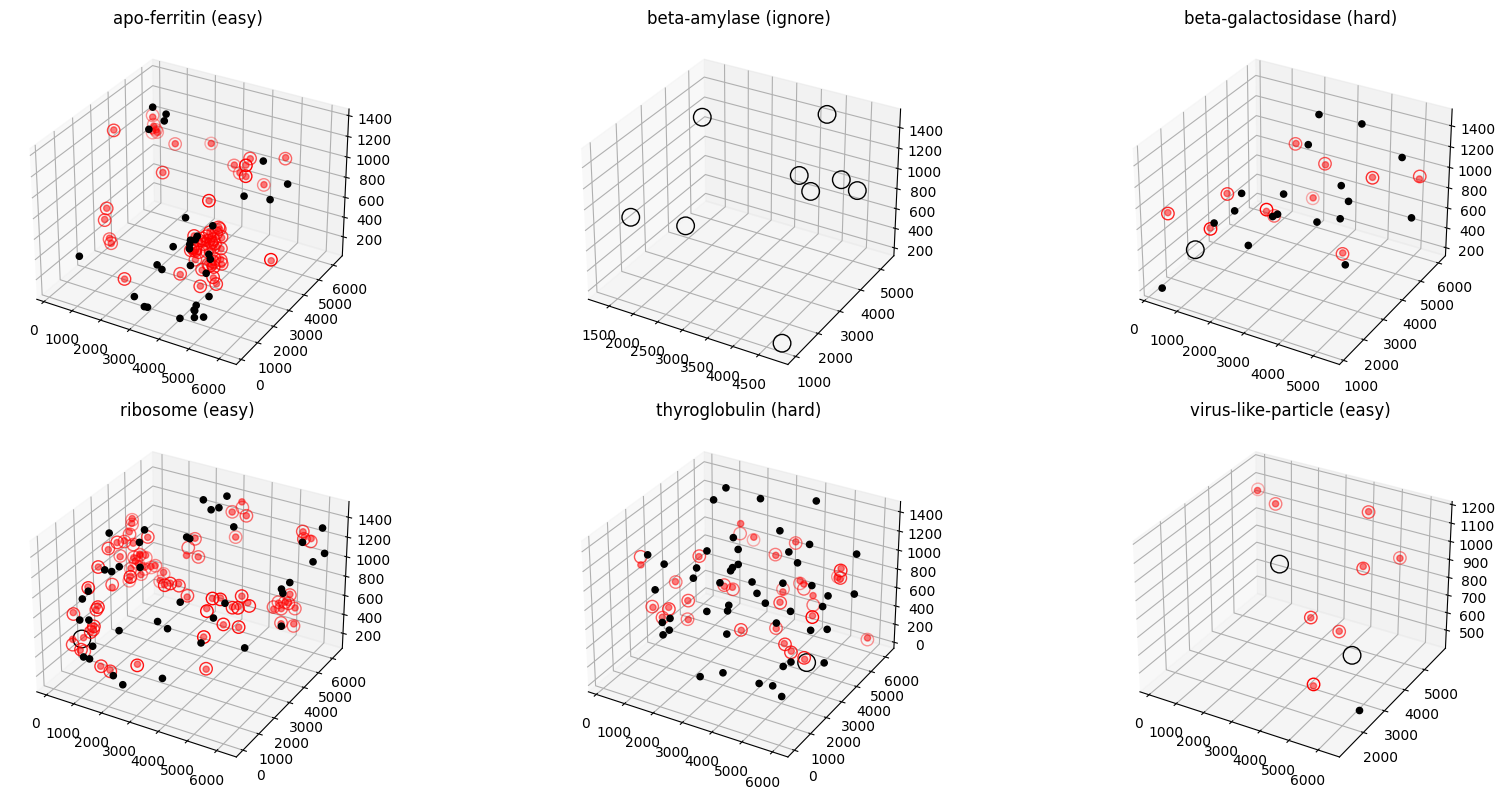

In [35]:
import os
if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    MODE = 'submit'
else:
    MODE = 'local'







valid_dir ='/kaggle/input/czii-cryo-et-object-identification/train'
valid_id = ['TS_6_4', ]

def do_one_eval(truth, predict, threshold):
    P=len(predict)
    T=len(truth)

    if P==0:
        hit=[[],[]]
        miss=np.arange(T).tolist()
        fp=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    if T==0:
        hit=[[],[]]
        fp=np.arange(P).tolist()
        miss=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    #---
    distance = predict.reshape(P,1,3)-truth.reshape(1,T,3)
    distance = distance**2
    distance = distance.sum(axis=2)
    distance = np.sqrt(distance)
    p_index, t_index = linear_sum_assignment(distance)

    valid = distance[p_index, t_index] <= threshold
    p_index = p_index[valid]
    t_index = t_index[valid]
    hit = [p_index.tolist(), t_index.tolist()]
    miss = np.arange(T)
    miss = miss[~np.isin(miss,t_index)].tolist()
    fp = np.arange(P)
    fp = fp[~np.isin(fp,p_index)].tolist()

    metric = [P,T,len(hit[0]),len(miss),len(fp)] #for lb metric F-beta copmutation
    return hit, fp, miss, metric


def compute_lb(submit_df, overlay_dir):
    valid_id = valid_id = ['TS_6_4', ]
    print(valid_id)

    eval_df = []
    for id in valid_id:
        truth = read_one_truth(id, overlay_dir) #=f'{valid_dir}/overlay/ExperimentRuns')
        id_df = submit_df[submit_df['experiment'] == id]
        for p in PARTICLE:
            p = dotdict(p)
            print('\r', id, p.name, end='', flush=True)
            xyz_truth = truth[p.name]
            xyz_predict = id_df[id_df['particle_type'] == p.name][['x', 'y', 'z']].values
            hit, fp, miss, metric = do_one_eval(xyz_truth, xyz_predict, p.radius* 0.5)
            eval_df.append(dotdict(
                id=id, particle_type=p.name,
                P=metric[0], T=metric[1], hit=metric[2], miss=metric[3], fp=metric[4],
            ))
    print('')
    eval_df = pd.DataFrame(eval_df)
    gb = eval_df.groupby('particle_type').agg('sum').drop(columns=['id'])
    gb.loc[:, 'precision'] = gb['hit'] / gb['P']
    gb.loc[:, 'precision'] = gb['precision'].fillna(0)
    gb.loc[:, 'recall'] = gb['hit'] / gb['T']
    gb.loc[:, 'recall'] = gb['recall'].fillna(0)
    gb.loc[:, 'f-beta4'] = 17 * gb['precision'] * gb['recall'] / (16 * gb['precision'] + gb['recall'])
    gb.loc[:, 'f-beta4'] = gb['f-beta4'].fillna(0)

    gb = gb.sort_values('particle_type').reset_index(drop=False)
    # https://www.kaggle.com/competitions/czii-cryo-et-object-identification/discussion/544895
    gb.loc[:, 'weight'] = [1, 0, 2, 1, 2, 1]
    lb_score = (gb['f-beta4'] * gb['weight']).sum() / gb['weight'].sum()
    return gb, lb_score


#debug
if 1:
    if MODE=='local':
    #if 1:
        submit_df=pd.read_csv(
           'submission.csv'
            # '/kaggle/input/hengck-czii-cryo-et-weights-01/submission.csv'
        )
        gb, lb_score = compute_lb(submit_df, f'{valid_dir}/overlay/ExperimentRuns')
        print(gb)
        print('lb_score:',lb_score)
        print('')


        #show one ----------------------------------
        fig = plt.figure(figsize=(18, 8))

        id = valid_id[0]
        truth = read_one_truth(id,overlay_dir=f'{valid_dir}/overlay/ExperimentRuns')

        submit_df = submit_df[submit_df['experiment']==id]
        for p in PARTICLE:
            p = dotdict(p)
            xyz_truth = truth[p.name]
            xyz_predict = submit_df[submit_df['particle_type']==p.name][['x','y','z']].values
            hit, fp, miss, _ = do_one_eval(xyz_truth, xyz_predict, p.radius)
            print(id, p.name)
            print('\t num truth   :',len(xyz_truth) )
            print('\t num predict :',len(xyz_predict) )
            print('\t num hit  :',len(hit[0]) )
            print('\t num fp   :',len(fp) )
            print('\t num miss :',len(miss) )

            ax = fig.add_subplot(2, 3, p.label, projection='3d')
            if hit[0]:
                pt = xyz_predict[hit[0]]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=0.5, color='r')
                pt = xyz_truth[hit[1]]
                ax.scatter(pt[:,0], pt[:,1], pt[:,2], s=80, facecolors='none', edgecolors='r')
            if fp:
                pt = xyz_predict[fp]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=1, color='k')
            if miss:
                pt = xyz_truth[miss]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], s=160, alpha=1, facecolors='none', edgecolors='k')

            ax.set_title(f'{p.name} ({p.difficulty})')

        plt.tight_layout()
        plt.show()
        
        #--- 
        zz=0

['TS_6_4', 'TS_5_4', 'TS_69_2']
 TS_69_2 virus-like-particle
         particle_type    P    T  hit  miss   fp  precision    recall  \
0         apo-ferritin  218  139  133     6   85   0.610092  0.956835   
1         beta-amylase    0   31    0    31    0   0.000000  0.000000   
2   beta-galactosidase   91   40   34     6   57   0.373626  0.850000   
3             ribosome  223  142  136     6   87   0.609865  0.957746   
4        thyroglobulin  260   94   86     8  174   0.330769  0.914894   
5  virus-like-particle   29   30   28     2    1   0.965517  0.933333   

    f-beta4  weight  
0  0.925880       1  
1  0.000000       0  
2  0.790698       2  
3  0.926653       1  
4  0.828798       2  
5  0.935167       1  
lb_score: 0.8609560639027197

TS_6_4 apo-ferritin
	 num truth   : 58
	 num predict : 91
	 num hit  : 58
	 num fp   : 33
	 num miss : 0
TS_6_4 beta-amylase
	 num truth   : 9
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 9
TS_6_4 beta-galactosidase
	 num truth

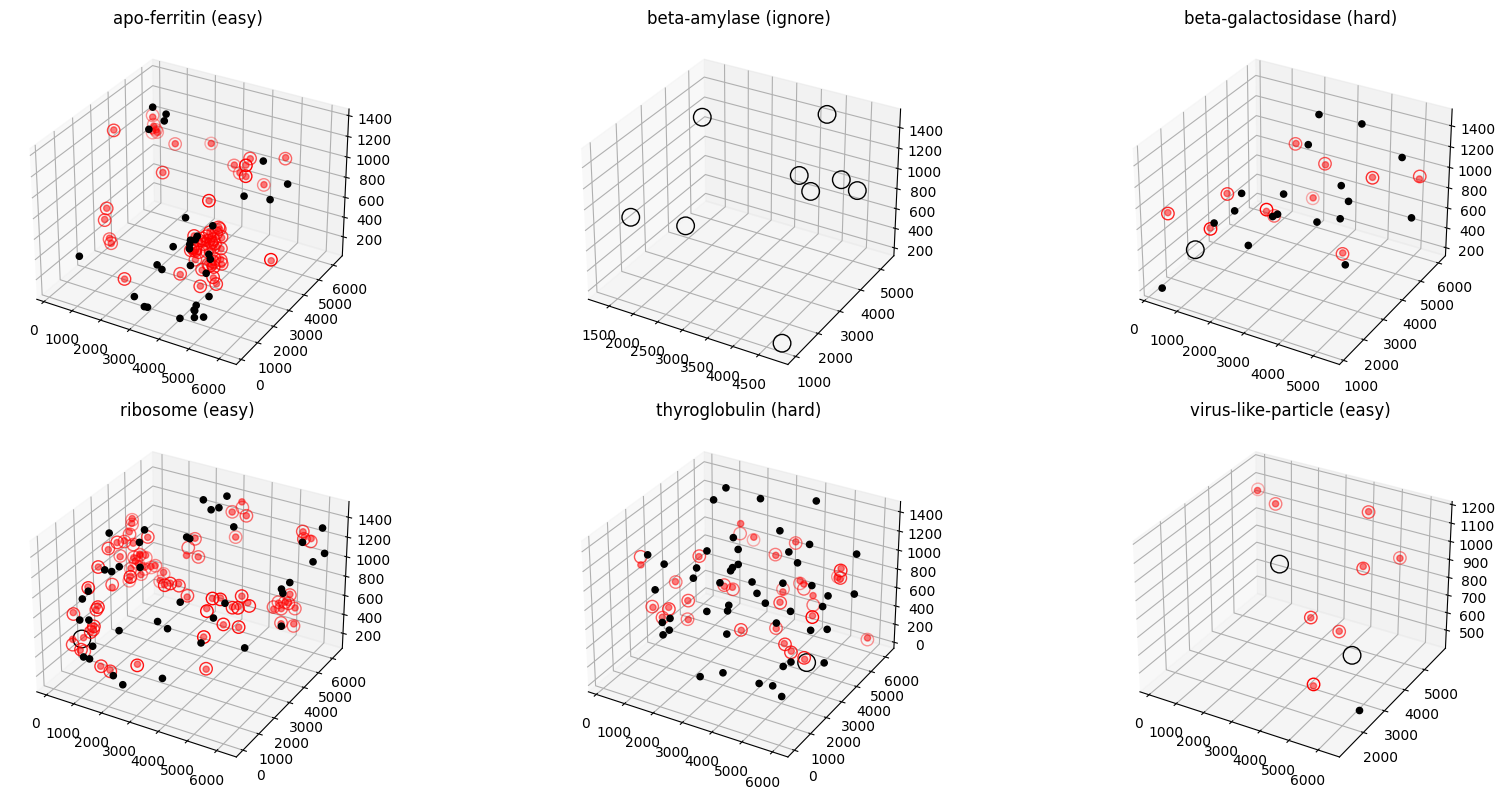

In [36]:
import os
if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    MODE = 'submit'
else:
    MODE = 'local'







valid_dir ='/kaggle/input/czii-cryo-et-object-identification/train'
valid_id = ['TS_6_4', ]

def do_one_eval(truth, predict, threshold):
    P=len(predict)
    T=len(truth)

    if P==0:
        hit=[[],[]]
        miss=np.arange(T).tolist()
        fp=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    if T==0:
        hit=[[],[]]
        fp=np.arange(P).tolist()
        miss=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    #---
    distance = predict.reshape(P,1,3)-truth.reshape(1,T,3)
    distance = distance**2
    distance = distance.sum(axis=2)
    distance = np.sqrt(distance)
    p_index, t_index = linear_sum_assignment(distance)

    valid = distance[p_index, t_index] <= threshold
    p_index = p_index[valid]
    t_index = t_index[valid]
    hit = [p_index.tolist(), t_index.tolist()]
    miss = np.arange(T)
    miss = miss[~np.isin(miss,t_index)].tolist()
    fp = np.arange(P)
    fp = fp[~np.isin(fp,p_index)].tolist()

    metric = [P,T,len(hit[0]),len(miss),len(fp)] #for lb metric F-beta copmutation
    return hit, fp, miss, metric


def compute_lb(submit_df, overlay_dir):
    valid_id = list(submit_df["experiment"].unique())
    print(valid_id)

    eval_df = []
    for id in valid_id:
        truth = read_one_truth(id, overlay_dir) #=f'{valid_dir}/overlay/ExperimentRuns')
        id_df = submit_df[submit_df['experiment'] == id]
        for p in PARTICLE:
            p = dotdict(p)
            print('\r', id, p.name, end='', flush=True)
            xyz_truth = truth[p.name]
            xyz_predict = id_df[id_df['particle_type'] == p.name][['x', 'y', 'z']].values
            hit, fp, miss, metric = do_one_eval(xyz_truth, xyz_predict, p.radius* 0.5)
            eval_df.append(dotdict(
                id=id, particle_type=p.name,
                P=metric[0], T=metric[1], hit=metric[2], miss=metric[3], fp=metric[4],
            ))
    print('')
    eval_df = pd.DataFrame(eval_df)
    gb = eval_df.groupby('particle_type').agg('sum').drop(columns=['id'])
    gb.loc[:, 'precision'] = gb['hit'] / gb['P']
    gb.loc[:, 'precision'] = gb['precision'].fillna(0)
    gb.loc[:, 'recall'] = gb['hit'] / gb['T']
    gb.loc[:, 'recall'] = gb['recall'].fillna(0)
    gb.loc[:, 'f-beta4'] = 17 * gb['precision'] * gb['recall'] / (16 * gb['precision'] + gb['recall'])
    gb.loc[:, 'f-beta4'] = gb['f-beta4'].fillna(0)

    gb = gb.sort_values('particle_type').reset_index(drop=False)
    # https://www.kaggle.com/competitions/czii-cryo-et-object-identification/discussion/544895
    gb.loc[:, 'weight'] = [1, 0, 2, 1, 2, 1]
    lb_score = (gb['f-beta4'] * gb['weight']).sum() / gb['weight'].sum()
    return gb, lb_score


#debug
if 1:
    if MODE=='local':
    #if 1:
        submit_df=pd.read_csv(
           'submission.csv'
            # '/kaggle/input/hengck-czii-cryo-et-weights-01/submission.csv'
        )
        gb, lb_score = compute_lb(submit_df, f'{valid_dir}/overlay/ExperimentRuns')
        print(gb)
        print('lb_score:',lb_score)
        print('')


        #show one ----------------------------------
        fig = plt.figure(figsize=(18, 8))

        id = valid_id[0]
        truth = read_one_truth(id,overlay_dir=f'{valid_dir}/overlay/ExperimentRuns')

        submit_df = submit_df[submit_df['experiment']==id]
        for p in PARTICLE:
            p = dotdict(p)
            xyz_truth = truth[p.name]
            xyz_predict = submit_df[submit_df['particle_type']==p.name][['x','y','z']].values
            hit, fp, miss, _ = do_one_eval(xyz_truth, xyz_predict, p.radius)
            print(id, p.name)
            print('\t num truth   :',len(xyz_truth) )
            print('\t num predict :',len(xyz_predict) )
            print('\t num hit  :',len(hit[0]) )
            print('\t num fp   :',len(fp) )
            print('\t num miss :',len(miss) )

            ax = fig.add_subplot(2, 3, p.label, projection='3d')
            if hit[0]:
                pt = xyz_predict[hit[0]]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=0.5, color='r')
                pt = xyz_truth[hit[1]]
                ax.scatter(pt[:,0], pt[:,1], pt[:,2], s=80, facecolors='none', edgecolors='r')
            if fp:
                pt = xyz_predict[fp]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=1, color='k')
            if miss:
                pt = xyz_truth[miss]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], s=160, alpha=1, facecolors='none', edgecolors='k')

            ax.set_title(f'{p.name} ({p.difficulty})')

        plt.tight_layout()
        plt.show()
        
        #--- 
        zz=0